In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import MinMaxScaler

seed = 1
n_cv = 3
n_bins = 10

In [2]:
data = scipy.io.arff.loadarff('Emotions.arff')
df = pd.DataFrame(data[0])

X_data = df.iloc[:, :-6].values
Y_data = df.iloc[:, -6:].values.astype('int')
X_data = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_data, Y_data)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=seed)

base_clf = MLPClassifier(hidden_layer_sizes=(X_train.shape[1]*2//3, X_train.shape[1]*1//3), max_iter=2**15, random_state=seed)

clfs = [
    ['Uncalibrated', OneVsRestClassifier(base_clf)],
    ['Isotonic', OneVsRestClassifier(CalibratedClassifierCV(estimator=base_clf, method='isotonic', cv=n_cv))],
    ['Platt', OneVsRestClassifier(CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv=n_cv))]
]

### Fully-supervised

Uncalibrated
Accuracy: 0.7801
ECE     : 0.2057
MCE:    : 0.3409

Isotonic
Accuracy: 0.8011
ECE     : 0.0294
MCE:    : 0.0908

Platt
Accuracy: 0.8123
ECE     : 0.0542
MCE:    : 0.1548



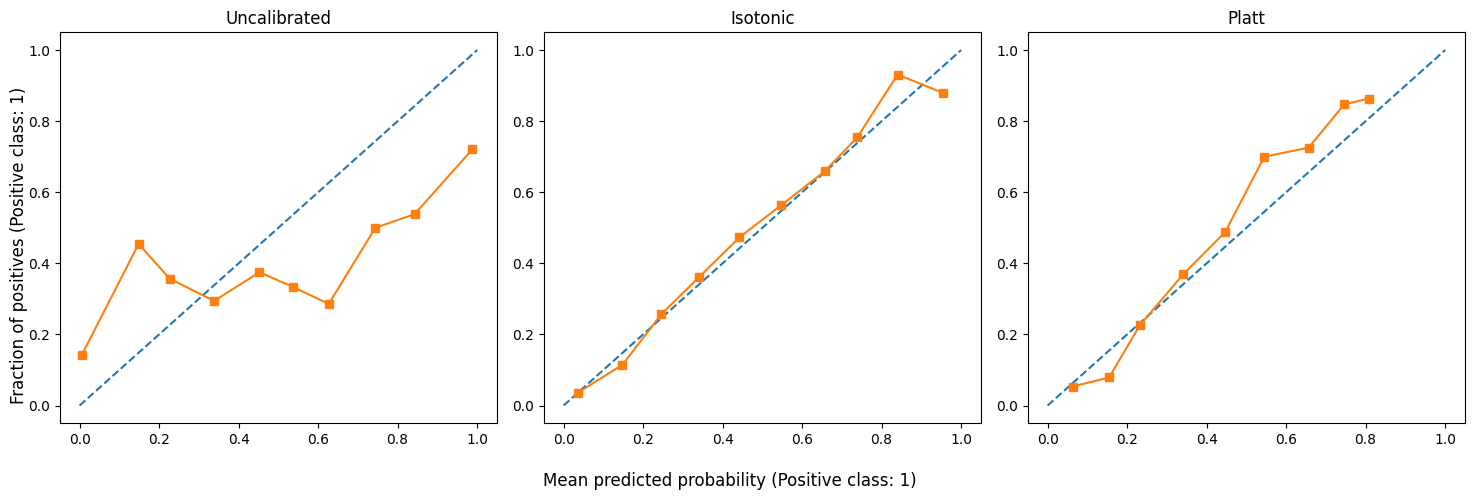

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
fig.supxlabel('Mean predicted probability (Positive class: 1)')
fig.supylabel('Fraction of positives (Positive class: 1)')

for ax in axes:
    ax.plot([0, 1], [0, 1], '--')
    
for ax_col, clf in enumerate(clfs):
    clf[1] = clf[1].fit(X_train, Y_train)
    bins = calibration_curve(Y_test.reshape(-1), clf[1].predict_proba(X_test).reshape(-1), n_bins=n_bins)
    axes[ax_col].set_title(clf[0])
    axes[ax_col].plot(bins[1], bins[0], '-s')
    
    acc = 0
    Y_pred = clf[1].predict(X_test)
    for j in range(len(Y_test)):
        acc += np.array(Y_test[j] == Y_pred[j]).sum()
    
    print(clf[0])
    print(f'Accuracy: {acc/(Y_test.shape[0]*Y_test.shape[1]):.4f}')
    print(f'ECE     : {np.abs(bins[0] - bins[1]).sum()/n_bins:.4f}')
    print(f'MCE:    : {np.abs(bins[0] - bins[1]).max():.4f}')
    print()

plt.tight_layout()
plt.show()

### Semi-supervised (µ = 0.5)

In [4]:
X_lab, X_unlab, Y_lab, _ = train_test_split(X_train, Y_train, test_size=0.5, random_state=seed)
X_new = np.concatenate((X_lab, X_unlab))

#### Label propagation

Uncalibrated
Accuracy: 0.7675
ECE     : 0.2563
MCE:    : 0.3887

Isotonic
Accuracy: 0.7899
ECE     : 0.0491
MCE:    : 0.2623

Platt
Accuracy: 0.7913
ECE     : 0.0580
MCE:    : 0.1831



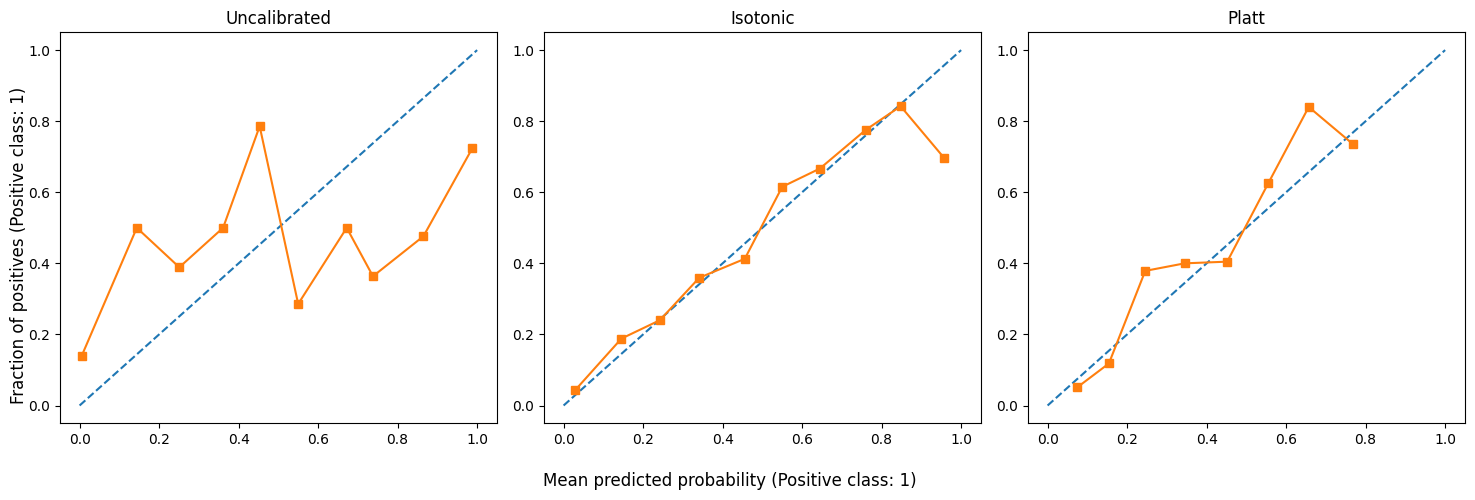

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
fig.supxlabel('Mean predicted probability (Positive class: 1)')
fig.supylabel('Fraction of positives (Positive class: 1)')

for ax in axes:
    ax.plot([0, 1], [0, 1], '--')

Y_new = []
for i in range(Y_train.shape[1]):
    temp = [-1 for _ in range(X_unlab.shape[0])]
    Y_temp = np.concatenate((Y_lab[:, i], temp))
    lp = LabelPropagation(max_iter=2**15).fit(X_new, Y_temp)
    Y_new.append(lp.transduction_)

Y_new = np.array(Y_new).transpose()

for ax_col, clf in enumerate(clfs):
    clf[1] = clf[1].fit(X_new, Y_new)
    bins = calibration_curve(Y_test.reshape(-1), clf[1].predict_proba(X_test).reshape(-1), n_bins=n_bins)
    axes[ax_col].set_title(clf[0])
    axes[ax_col].plot(bins[1], bins[0], '-s')
    
    acc = 0
    Y_pred = clf[1].predict(X_test)
    for j in range(len(Y_test)):
        acc += np.array(Y_test[j] == Y_pred[j]).sum()
    
    print(clf[0])
    print(f'Accuracy: {acc/(Y_test.shape[0]*Y_test.shape[1]):.4f}')
    print(f'ECE     : {np.abs(bins[0] - bins[1]).sum()/n_bins:.4f}')
    print(f'MCE:    : {np.abs(bins[0] - bins[1]).max():.4f}')
    print()

plt.tight_layout()
plt.show()

#### Pseudo-labelling

Uncalibrated
Accuracy: 0.7675
ECE     : 0.2161
MCE:    : 0.4979

Isotonic
Accuracy: 0.7843
ECE     : 0.1114
MCE:    : 0.2949

Platt
Accuracy: 0.7801
ECE     : 0.1082
MCE:    : 0.2151



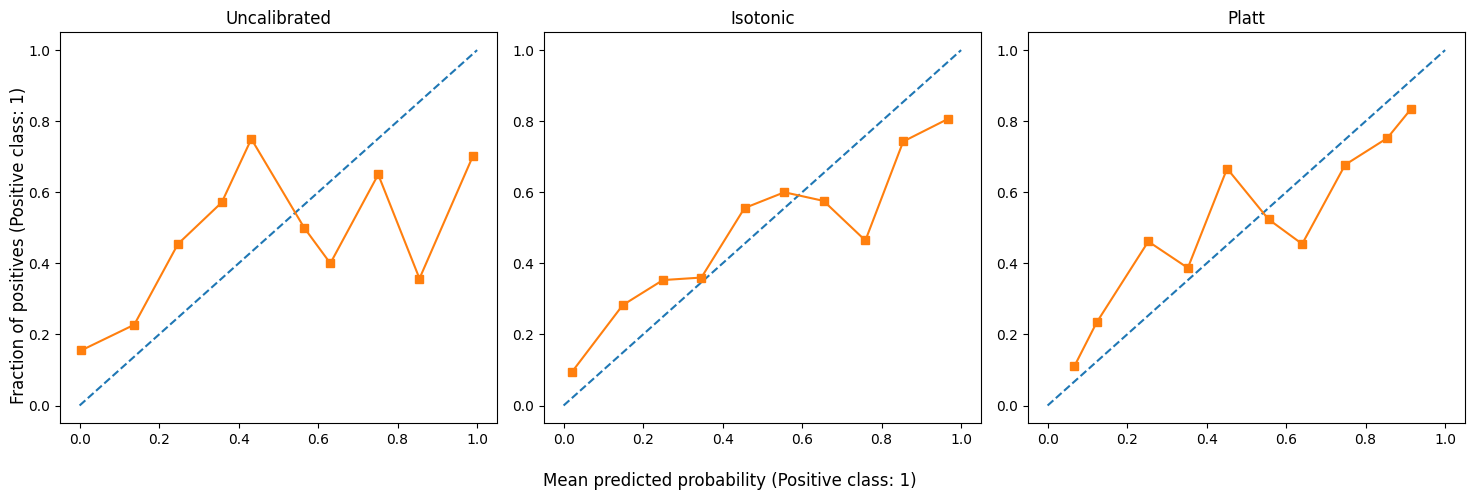

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
fig.supxlabel('Mean predicted probability (Positive class: 1)')
fig.supylabel('Fraction of positives (Positive class: 1)')

for ax in axes:
    ax.plot([0, 1], [0, 1], '--')

ps_clf = clfs[0][1].fit(X_lab, Y_lab)
Y_new = np.concatenate((Y_lab, ps_clf.predict_proba(X_unlab) > 0.75))

for ax_col, clf in enumerate(clfs):
    clf[1] = clf[1].fit(X_new, Y_new)
    bins = calibration_curve(Y_test.reshape(-1), clf[1].predict_proba(X_test).reshape(-1), n_bins=n_bins)
    axes[ax_col].set_title(clf[0])
    axes[ax_col].plot(bins[1], bins[0], '-s')
    
    acc = 0
    Y_pred = clf[1].predict(X_test)
    for j in range(len(Y_test)):
        acc += np.array(Y_test[j] == Y_pred[j]).sum()
    
    print(clf[0])
    print(f'Accuracy: {acc/(Y_test.shape[0]*Y_test.shape[1]):.4f}')
    print(f'ECE     : {np.abs(bins[0] - bins[1]).sum()/n_bins:.4f}')
    print(f'MCE:    : {np.abs(bins[0] - bins[1]).max():.4f}')
    print()
    
plt.tight_layout()
plt.show()

### Semi-supervised (µ = 0.8)

In [7]:
X_lab, X_unlab, Y_lab, _ = train_test_split(X_train, Y_train, test_size=0.8, random_state=seed)
X_new = np.concatenate((X_lab, X_unlab))

#### Label propagation

Uncalibrated
Accuracy: 0.7521
ECE     : 0.2036
MCE:    : 0.5535

Isotonic
Accuracy: 0.7689
ECE     : 0.0740
MCE:    : 0.1225

Platt
Accuracy: 0.7745
ECE     : 0.0649
MCE:    : 0.2450



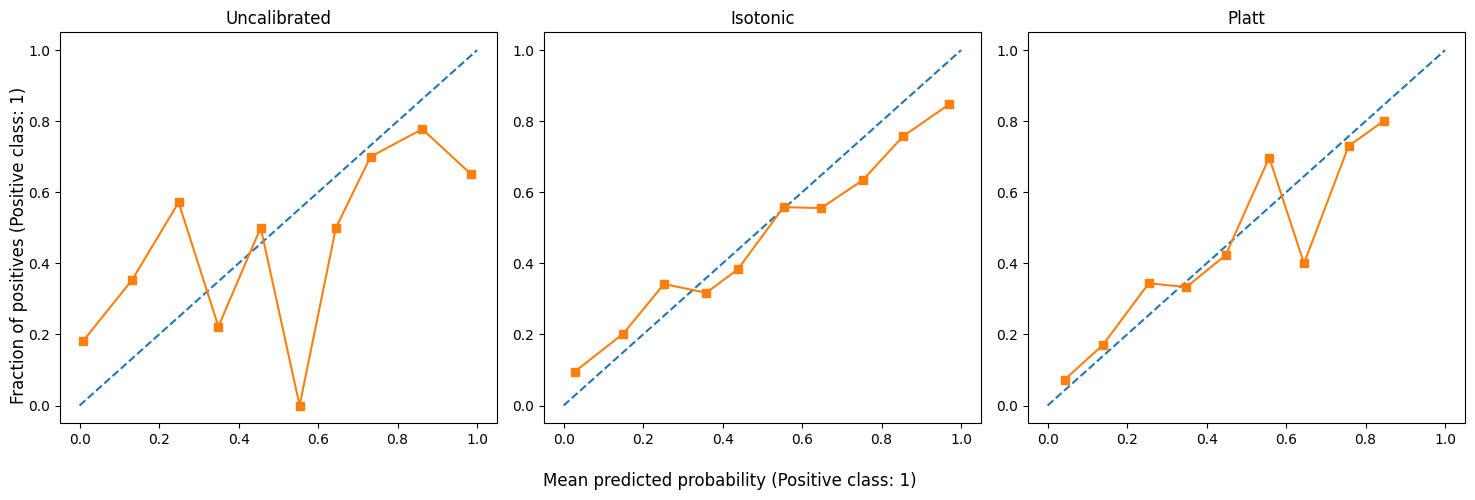

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
fig.supxlabel('Mean predicted probability (Positive class: 1)')
fig.supylabel('Fraction of positives (Positive class: 1)')

for ax in axes:
    ax.plot([0, 1], [0, 1], '--')

Y_new = []
for i in range(Y_train.shape[1]):
    temp = [-1 for _ in range(X_unlab.shape[0])]
    Y_temp = np.concatenate((Y_lab[:, i], temp))
    lp = LabelPropagation(max_iter=2**15).fit(X_new, Y_temp)
    Y_new.append(lp.transduction_)

Y_new = np.array(Y_new).transpose()

for ax_col, clf in enumerate(clfs):
    clf[1] = clf[1].fit(X_new, Y_new)
    bins = calibration_curve(Y_test.reshape(-1), clf[1].predict_proba(X_test).reshape(-1), n_bins=n_bins)
    axes[ax_col].set_title(clf[0])
    axes[ax_col].plot(bins[1], bins[0], '-s')
    
    acc = 0
    Y_pred = clf[1].predict(X_test)
    for j in range(len(Y_test)):
        acc += np.array(Y_test[j] == Y_pred[j]).sum()
    
    print(clf[0])
    print(f'Accuracy: {acc/(Y_test.shape[0]*Y_test.shape[1]):.4f}')
    print(f'ECE     : {np.abs(bins[0] - bins[1]).sum()/n_bins:.4f}')
    print(f'MCE:    : {np.abs(bins[0] - bins[1]).max():.4f}')
    print()

plt.tight_layout()
plt.show()

#### Pseudo-labelling

Uncalibrated
Accuracy: 0.7521
ECE     : 0.2845
MCE:    : 0.6332

Isotonic
Accuracy: 0.7591
ECE     : 0.1676
MCE:    : 0.2937

Platt
Accuracy: 0.7675
ECE     : 0.1854
MCE:    : 0.4367



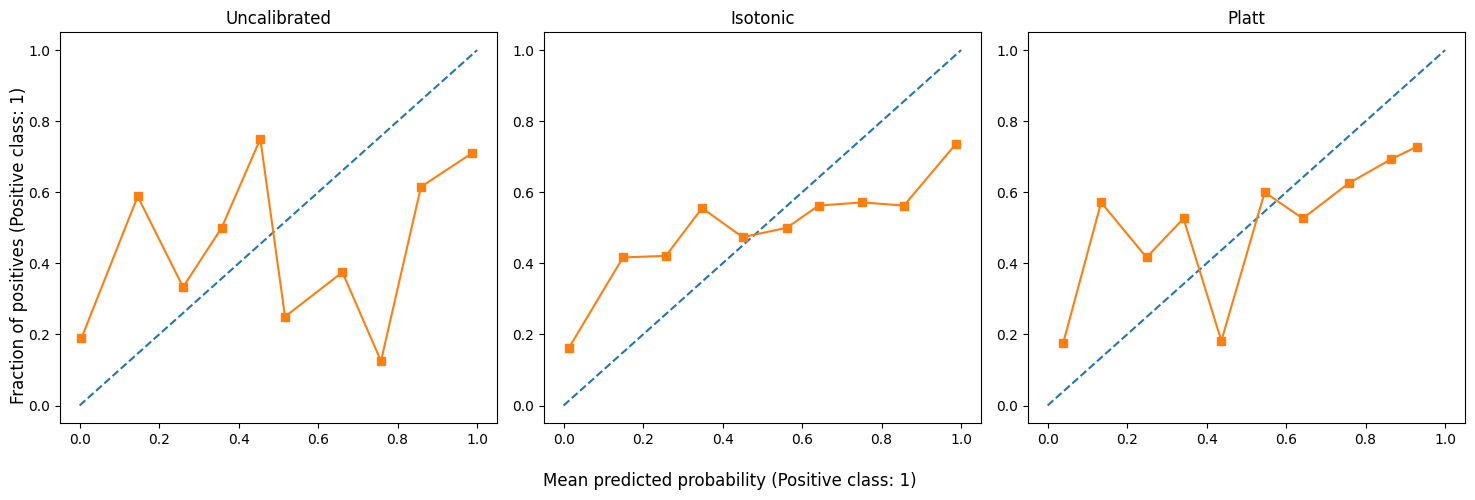

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
fig.supxlabel('Mean predicted probability (Positive class: 1)')
fig.supylabel('Fraction of positives (Positive class: 1)')

for ax in axes:
    ax.plot([0, 1], [0, 1], '--')

ps_clf = clfs[0][1].fit(X_lab, Y_lab)
Y_new = np.concatenate((Y_lab, ps_clf.predict_proba(X_unlab) > 0.75))

for ax_col, clf in enumerate(clfs):
    clf[1] = clf[1].fit(X_new, Y_new)
    bins = calibration_curve(Y_test.reshape(-1), clf[1].predict_proba(X_test).reshape(-1), n_bins=n_bins)
    axes[ax_col].set_title(clf[0])
    axes[ax_col].plot(bins[1], bins[0], '-s')
    
    acc = 0
    Y_pred = clf[1].predict(X_test)
    for j in range(len(Y_test)):
        acc += np.array(Y_test[j] == Y_pred[j]).sum()
    
    print(clf[0])
    print(f'Accuracy: {acc/(Y_test.shape[0]*Y_test.shape[1]):.4f}')
    print(f'ECE     : {np.abs(bins[0] - bins[1]).sum()/n_bins:.4f}')
    print(f'MCE:    : {np.abs(bins[0] - bins[1]).max():.4f}')
    print()
    
plt.tight_layout()
plt.show()